In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sbs

In [7]:
# Parameters
#perf_csv = "../../a2a-benchmarks/results-yasmin/parsec-simsmall-shared-perf-1node-nosmt.csv"
perf_csv = "../results-yasmin/parsec-phoenix-simsmall.csv"
fence_csv = "../results-yasmin/parsec-phoenix-fences.csv"

In [8]:
# Load csv files
perf_df = pd.read_csv(perf_csv, sep=';')
fence_df = pd.read_csv(fence_csv, sep=';')
perf_df

,arch,bench,cmdline,dataset,retval,threads,unit,value,runtime,tag
0,x86_64,parsec.blackscholes,/home/redha/benchmarks/parsec-benchmark-x86_64...,simsmall,0.0,28.0,seconds,0.418948,qemu,master
1,x86_64,parsec.blackscholes,/home/redha/benchmarks/parsec-benchmark-x86_64...,simsmall,0.0,28.0,seconds,0.416781,qemu,master
2,x86_64,parsec.blackscholes,/home/redha/benchmarks/parsec-benchmark-x86_64...,simsmall,0.0,28.0,seconds,0.416291,qemu,master
3,x86_64,parsec.blackscholes,/home/redha/benchmarks/parsec-benchmark-x86_64...,simsmall,0.0,28.0,seconds,0.416187,qemu,master
4,x86_64,parsec.blackscholes,/home/redha/benchmarks/parsec-benchmark-x86_64...,simsmall,0.0,28.0,seconds,0.417345,qemu,master
...,...,...,...,...,...,...,...,...,...,...
135,x86_64,phoenix.kmeans,/home/redha/benchmarks/phoenix-x86_64-shared/p...,large,0.0,28.0,seconds,2.936912,qemu,no-fences
136,x86_64,phoenix.kmeans,/home/redha/benchmarks/phoenix-x86_64-shared/p...,large,0.0,28.0,seconds,2.932823,qemu,no-fences
137,x86_64,phoenix.kmeans,/home/redha/benchmarks/phoenix-x86_64-shared/p...,large,0.0,28.0,seconds,2.941338,qemu,no-fences
138,x86_64,phoenix.kmeans,/home/redha/benchmarks/phoenix-x86_64-shared/p...,large,0.0,28.0,seconds,2.944391,qemu,no-fences


In [9]:
fence_df

,bench,accesses,fences
0,parsec.blackscholes,141465382,26248166
1,parsec.bodytrack,3516333874,151075755
2,parsec.canneal,694541119,26234881
3,parsec.fluidanimate,4121782137,162614441
4,parsec.freqmine,697072001,116335240
5,parsec.streamcluster,7236036845,1176131651
6,parsec.swaptions,2009628310,131593153
7,parsec.vips,4320102705,318614099
8,phoenix.histogram,412111306,17402314
9,phoenix.kmeans,7988711371,4204247662


In [10]:
bench_list = set(fence_df['bench'].values)
bench_list

{'parsec.blackscholes',
 'parsec.bodytrack',
 'parsec.canneal',
 'parsec.fluidanimate',
 'parsec.freqmine',
 'parsec.streamcluster',
 'parsec.swaptions',
 'parsec.vips',
 'phoenix.histogram',
 'phoenix.kmeans',
 'phoenix.linearregression',
 'phoenix.stringmatch',
 'phoenix.wordcount'}

In [11]:
fence_time = {}
fence_needed = []
improv = {}
runtime = []
base_means = {}
for b in bench_list:
    # Compute the time spent on fences
    b_perf_df = perf_df.loc[perf_df['bench'] == b]
    b_master_perf_df = b_perf_df.loc[b_perf_df['tag'] == 'master']
    b_no_fences_perf_df = b_perf_df.loc[b_perf_df['tag'] == 'no-fences']

    time = b_master_perf_df['value'].mean() - b_no_fences_perf_df['value'].mean()
    pct = time / b_master_perf_df['value'].mean()

    # Compute the ratio of (un)needed fences
    nr_accesses = fence_df.loc[(fence_df['bench'] == b)]['accesses'].values[0]
    nr_fences   = fence_df.loc[(fence_df['bench'] == b)]['fences'].values[0]
    fence_pct = nr_fences / nr_accesses
    fence_needed.append({ 'bench': b, 'pct': fence_pct * 100 })

    # Compute the improvement with only needed fences
    improv[b] = (1 - fence_pct) * pct
    runtime.append({ 'bench': b, 'type': 'Risotto-hw', 'pct': 100 * (1 - improv[b]) })
    runtime.append({ 'bench': b, 'type': 'no fences',
                     'pct': 100 * b_no_fences_perf_df['value'].mean() / b_master_perf_df['value'].mean() })

    base_means[b] = b_master_perf_df['value'].mean()

# Transform dicts in dataframes
res_fence = pd.DataFrame(fence_needed)
res_runtime = pd.DataFrame(runtime)

In [12]:
base_means

{'phoenix.stringmatch': 1.9614603042602539,
 'phoenix.wordcount': 1.4016012668609619,
 'parsec.blackscholes': 0.41711034774780276,
 'parsec.vips': 4.747879505157471,
 'parsec.freqmine': 2.1034780979156493,
 'phoenix.linearregression': 0.5326325416564941,
 'parsec.canneal': 15.541692018508911,
 'parsec.bodytrack': 8.839283275604249,
 'phoenix.histogram': 0.7260799884796143,
 'parsec.swaptions': 2.7754624843597413,
 'phoenix.kmeans': 10.028303289413453,
 'parsec.fluidanimate': 7.186456632614136,
 'parsec.streamcluster': 4.65947413444519}

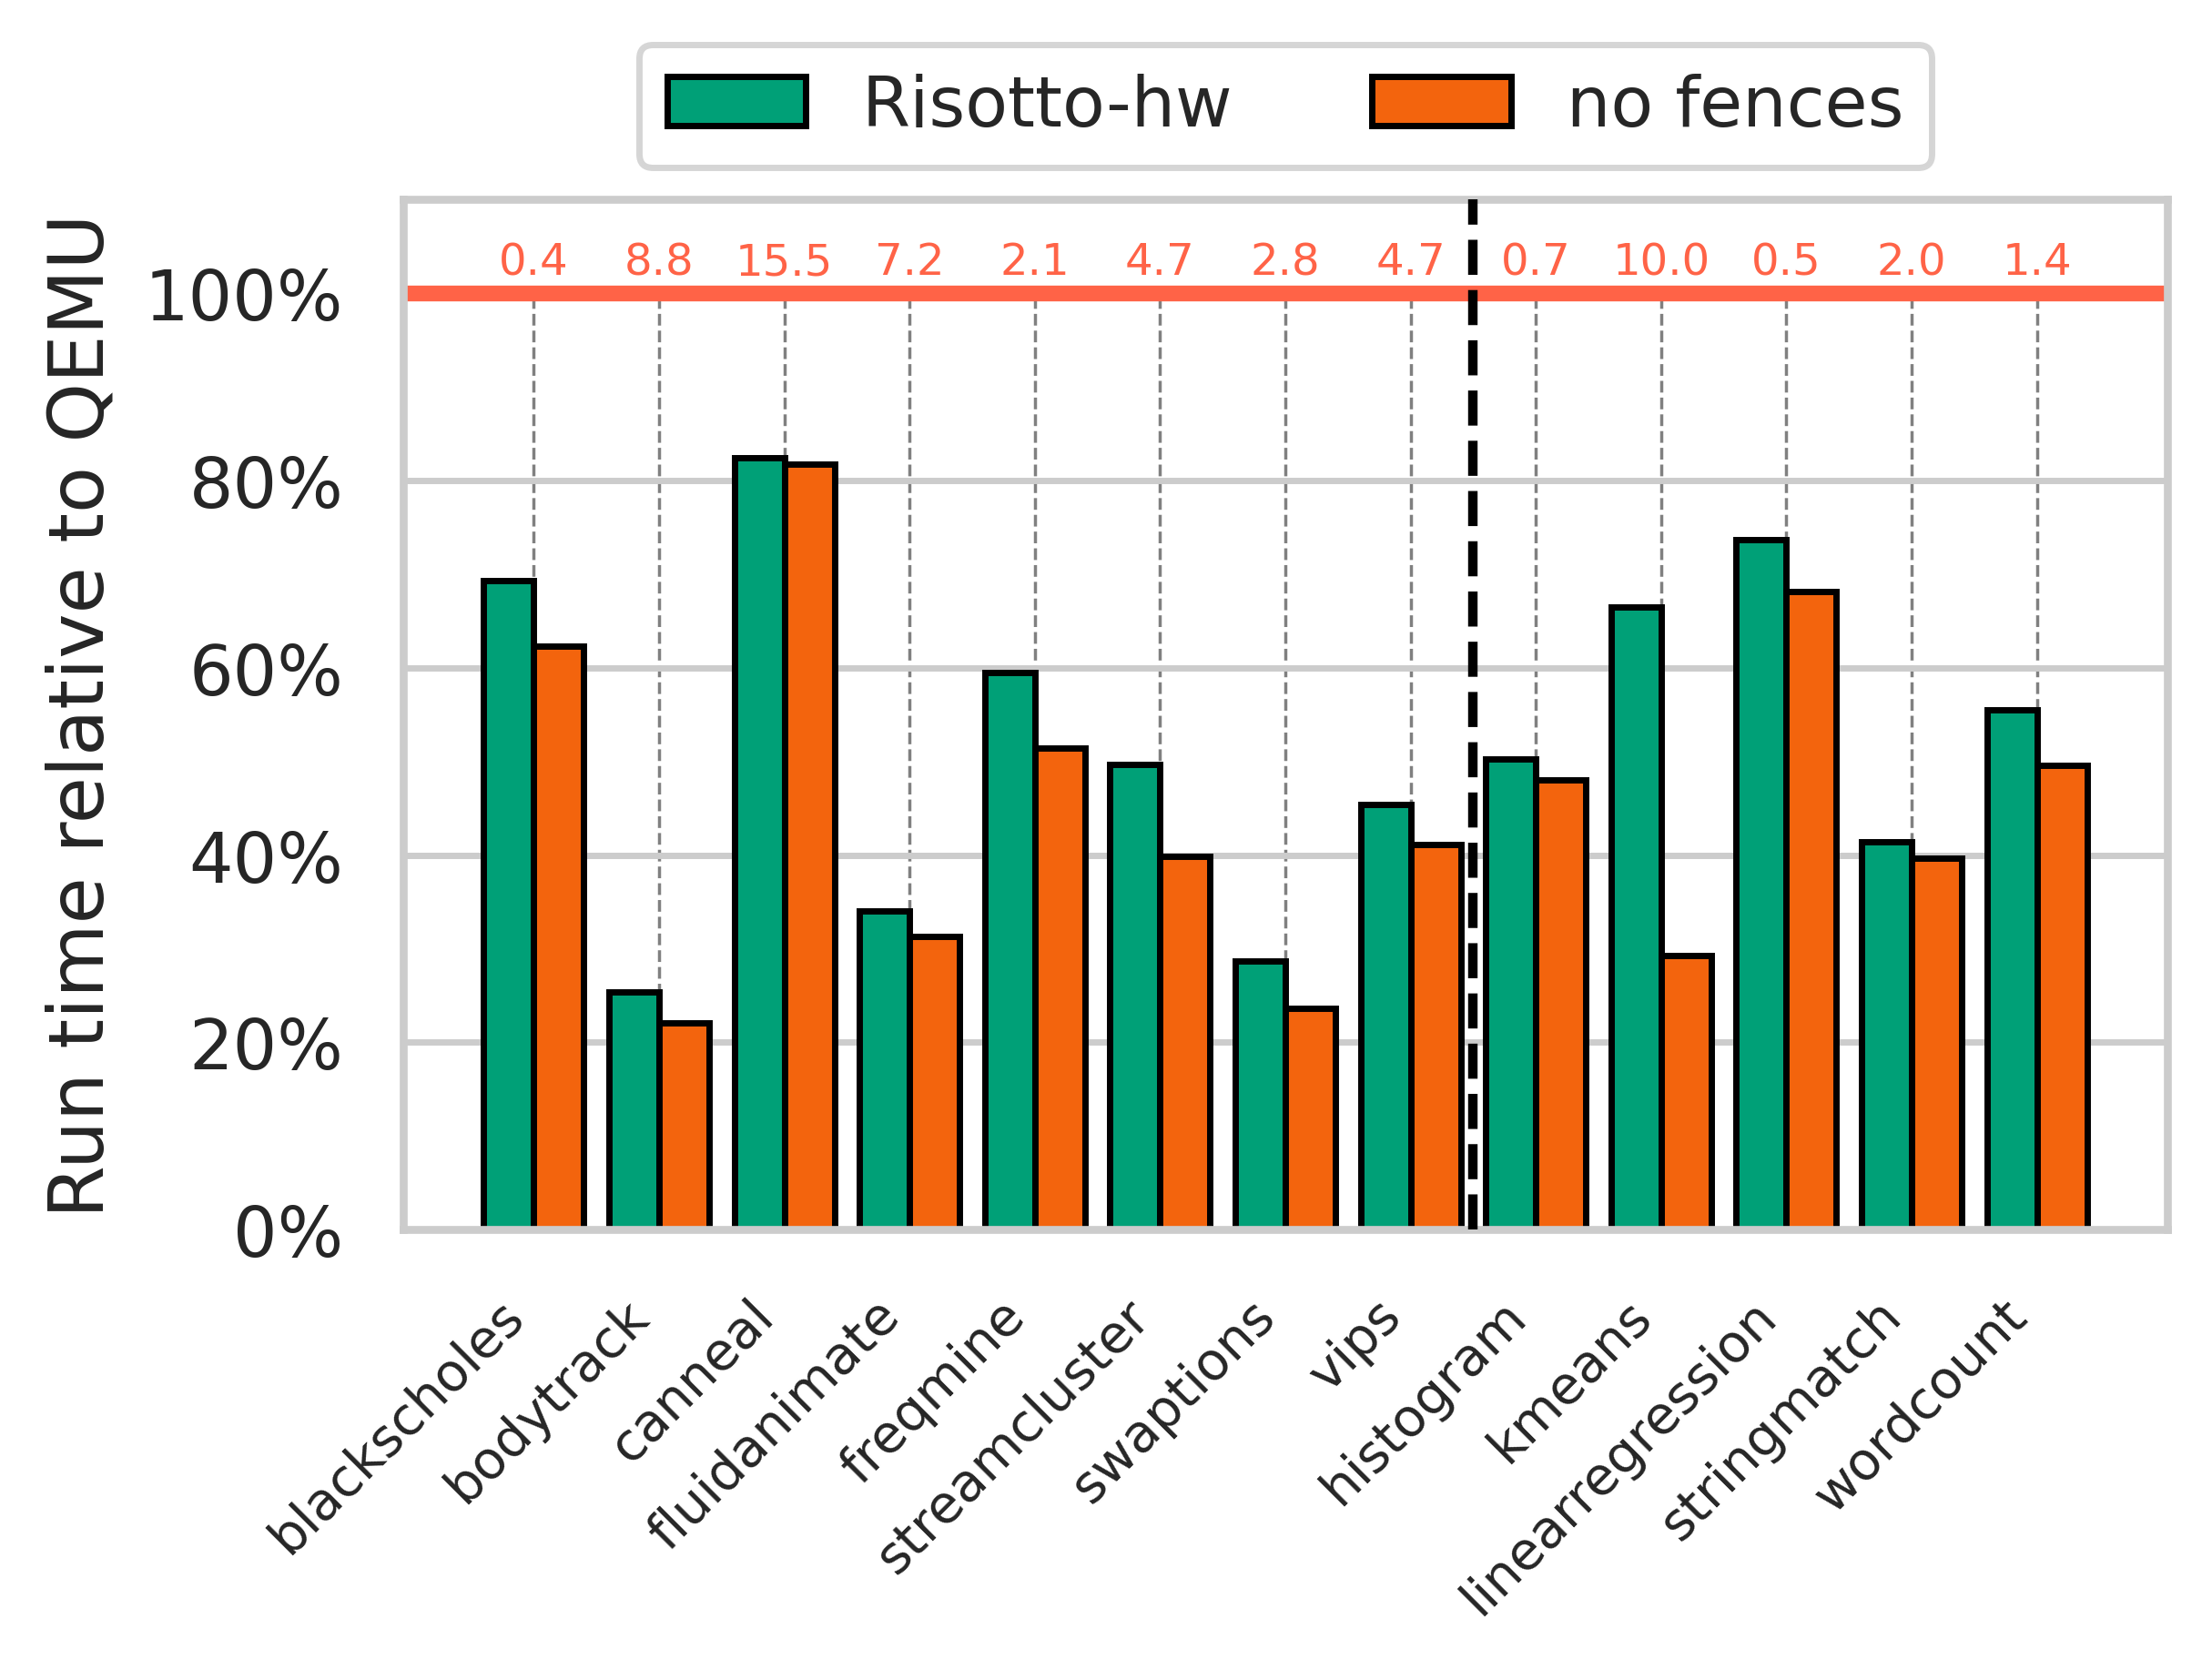

In [13]:
# refactor xticks to remove benchmark suite prefix
xlabels = []
xticks = []
for idx, b in enumerate(sorted(bench_list)):
    if b.startswith("parsec."):
        xlabels.append(b[7:])
        xticks.append(idx)
    else:
        xlabels.append(b[8:])
        xticks.append(idx)


# Plot run time pct
fig = plt.figure(figsize=(5, 3), dpi=500)
sbs.set(style="whitegrid")
palette = {
    'orange': '#faa200',
    'sky blue': '#00b7ec',
    'bluish green': '#00a077',
    'yellow': '#f5e636',
    'blue': '#0077b8',
    'vermillion': '#f3640d',
    'reddish purple': '#e47ead'
}
ax = sbs.barplot(data=res_runtime, x='bench', y='pct', hue='type',
                 order=sorted(bench_list))

plt.grid(visible=True, axis='y')
plt.xticks(ticks=xticks, labels=xlabels, rotation=45, ha="right", fontsize='x-small')
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Run time relative to QEMU")
ax.set_ylim([0, 110])
plt.yticks(ticks=np.arange(0, 101, 20))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.axhline(y=100, xmin=0, xmax=1, color='tomato', linewidth=2.5)
# Annotate the raw value of the baseline
for idx, value in enumerate(sorted(set(base_means))):
    plt.text(idx, 102, f"{base_means[value]:.1f}", fontsize='xx-small', color='tomato', ha='center')
plt.vlines(range(0, len(base_means)), ymin=0, ymax=100, linestyle='dashed', colors='grey',
           linewidth=.5, zorder=0)
    
# Set color + hatch
style = {
    'fill': [ True, True ],
    'color': [ palette['bluish green'], palette['vermillion'] ],
    'hatch': [ '', '', ''],
    'edgecolor': [ 'black', 'black', 'black' ]
}
for idx, bar in enumerate(ax.patches):
    bar_nr = int(idx / int(len(res_runtime) / 2))
    bar.set(color=style['color'][bar_nr], fill=style['fill'][bar_nr],
            hatch=style['hatch'][bar_nr], edgecolor=style['edgecolor'][bar_nr])
    
# parsec / phoenix separation
plt.vlines([ 7.5 ], ymin=0, ymax=110, linestyle='dashed', colors='black', linewidth=1.5, zorder=10)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), borderaxespad=0, ncol=4)

In [14]:
fig.savefig(f"{fence_csv[:-4]}-perf.pdf", dpi=500, bbox_inches='tight')

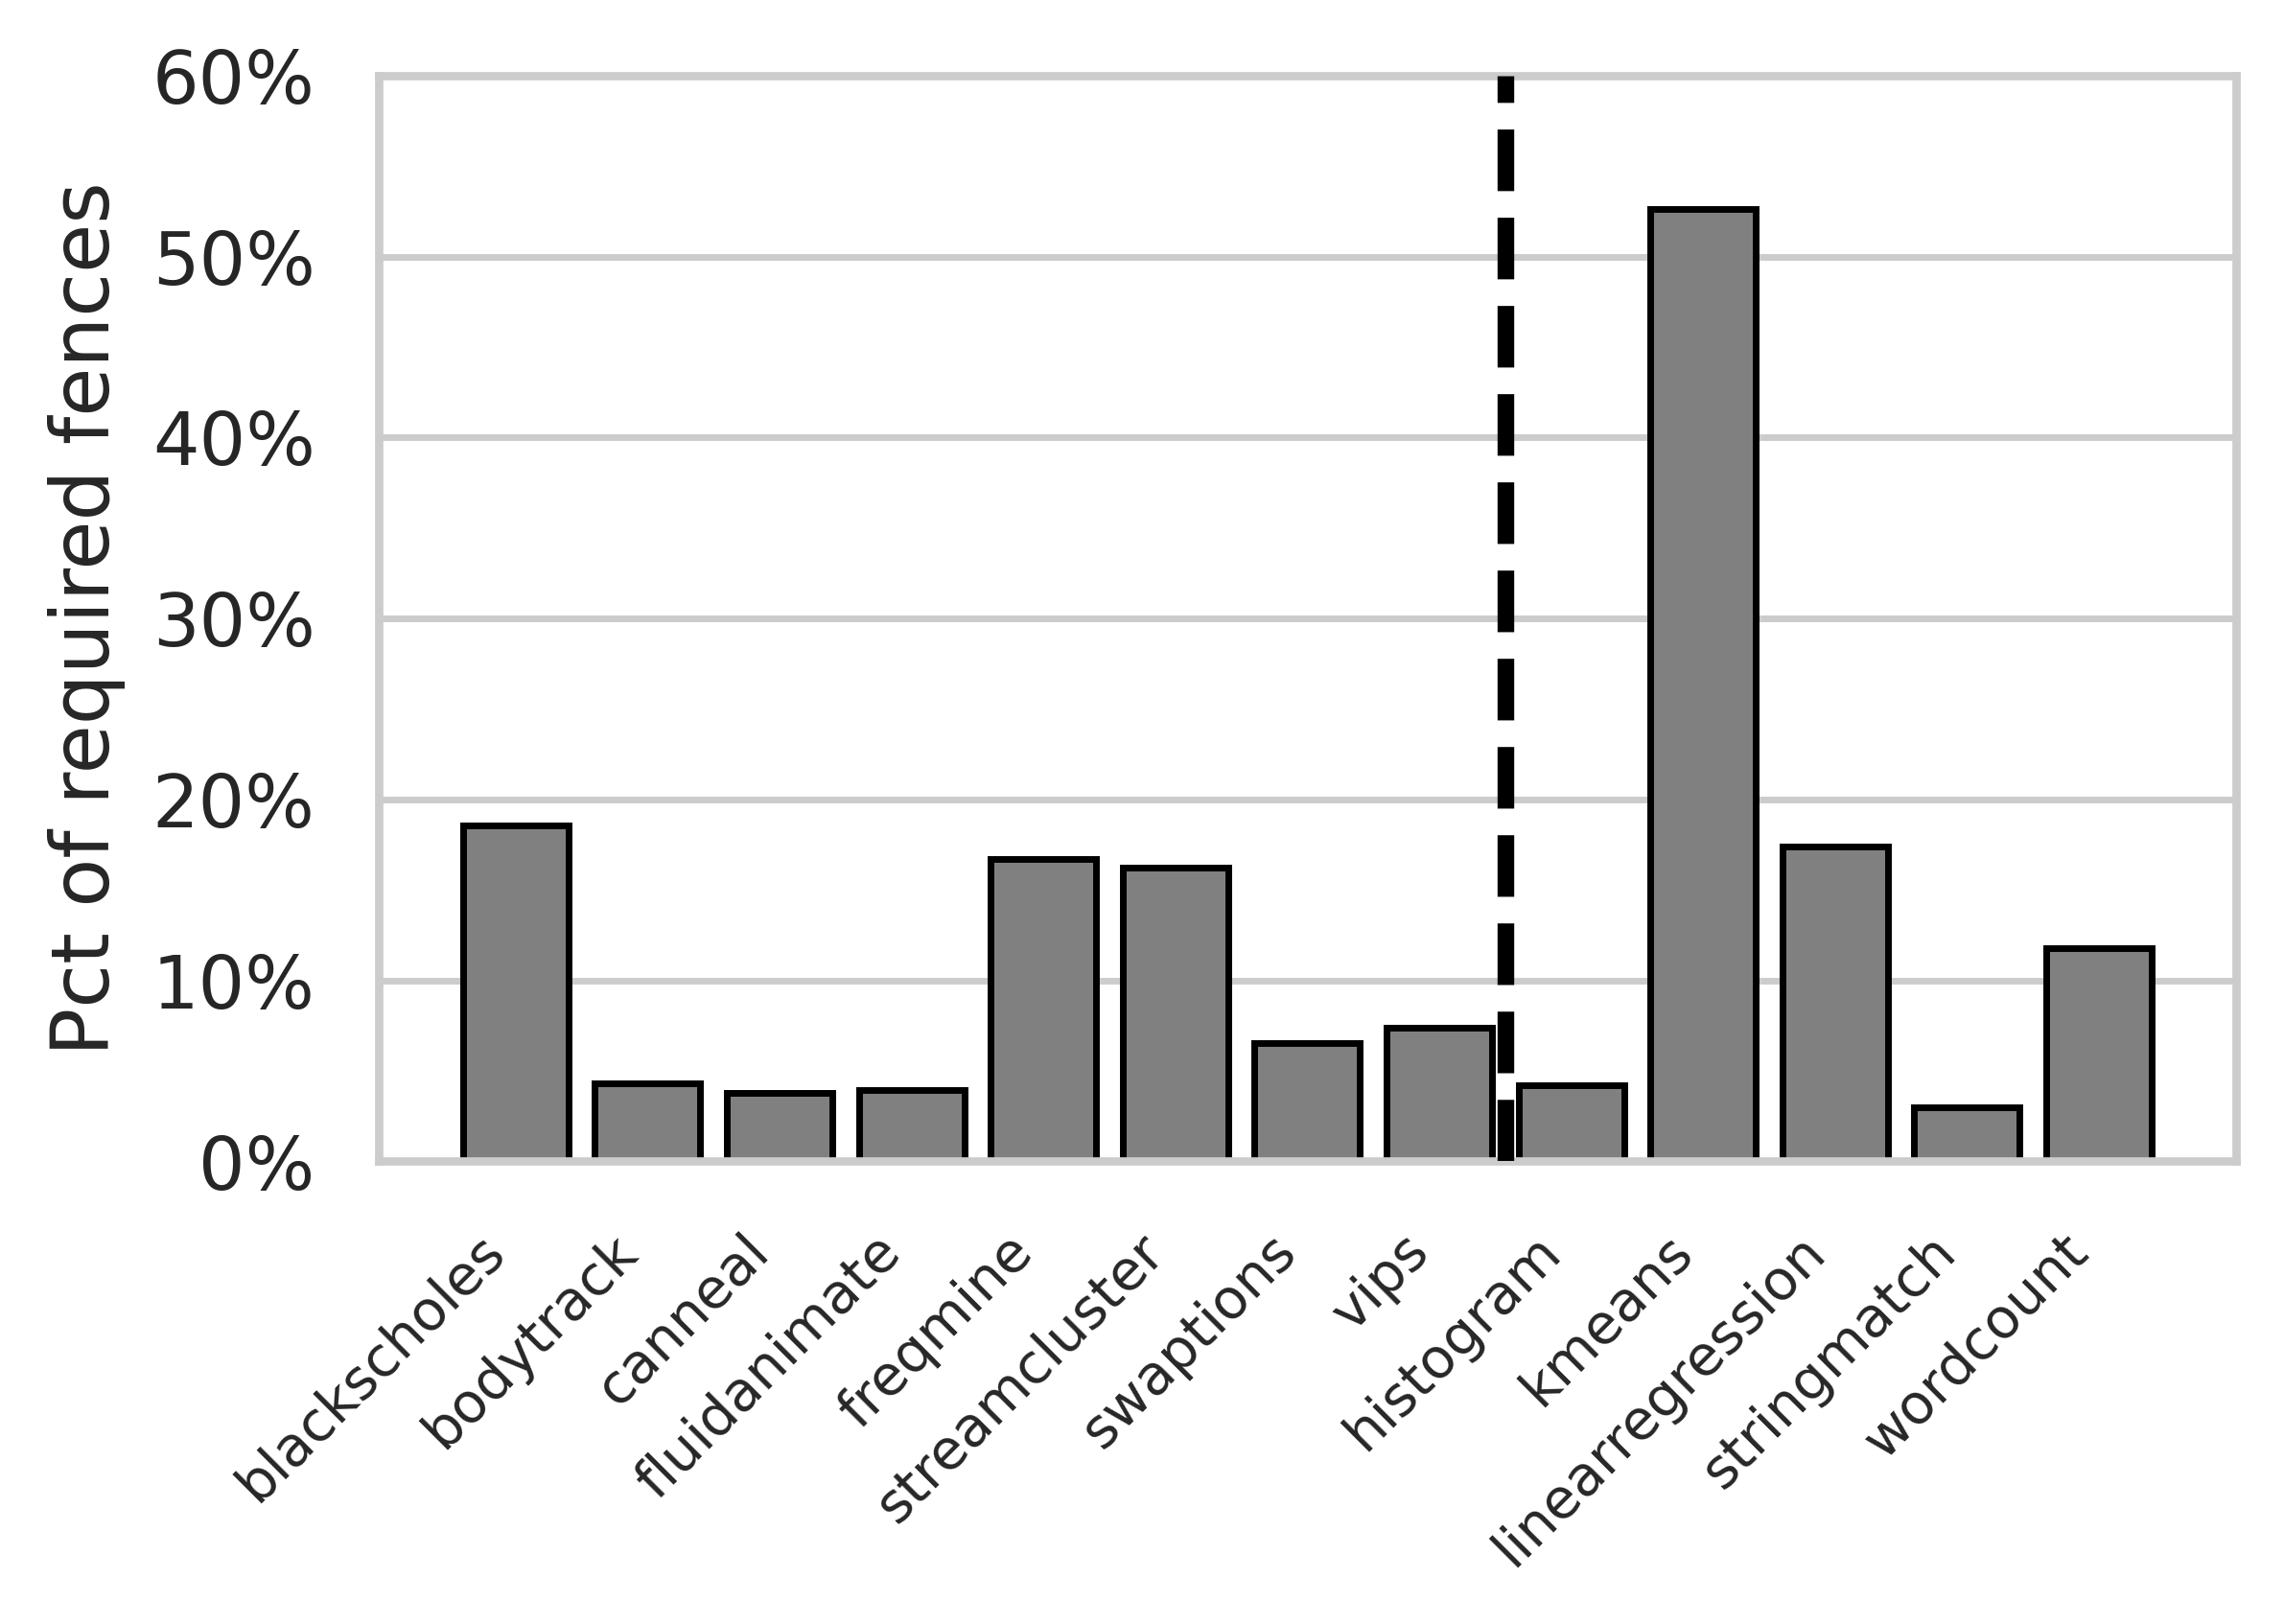

In [15]:
# Plot needed fence percentage
fig = plt.figure(figsize=(5, 3), dpi=500)
sbs.set(style="whitegrid")
ax = sbs.barplot(data=res_fence, x='bench', y='pct',
                 order=sorted(bench_list),
                 color='grey', edgecolor='black')

plt.grid(visible=True, axis='y')
plt.xticks(ticks=xticks, labels=xlabels, rotation=45, ha="right", fontsize='x-small')
ax.set_axisbelow(True)
plt.xlabel("")
plt.ylabel("Pct of required fences")
plt.ylim((0,60))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
# parsec / phoenix separation
plt.vlines([ 7.5 ], ymin=0, ymax=60, linestyle='dashed', colors='black', linewidth=2.5, zorder=10)

In [16]:
fig.savefig(f"{fence_csv[:-4]}-pct.pdf", dpi=500, bbox_inches='tight')